# **Brain Tumor Multimodal Image (CT & MRI) Classification**

The goal is to build and optimize a model to accurately detect and classify brain tumors using a multimodal dataset of CT and MRI scans. 

## 1) Setting Up

### __a) Importing Libraries__

In [346]:
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import random
import pandas as pd
import cv2
sns.set()

### __b) Read and add all data in an array__

In [347]:
#I imported it locally, however, It can be done with any method preferred. 
dataDirectory = "../data"

ctHealthyPath = glob.glob(os.path.join(dataDirectory, "CT", "Healthy", "*.jpg"))
ctTumorPath  = glob.glob(os.path.join(dataDirectory, "CT", "Tumor", "*.jpg"))

mriHealthyPath = glob.glob(os.path.join(dataDirectory, "MRI", "Healthy", "*.jpg"))
mriTumorPath  = glob.glob(os.path.join(dataDirectory, "MRI", "Tumor", "*.jpg"))


data = []

#CT Scan: Healthy and Tumor
for path in ctHealthyPath:
    data.append((path, 0, "CT"))
for path in ctTumorPath:
    data.append((path, 1, "CT"))

#MRI Scan: Healthy and Tumor
for path in mriHealthyPath:
    data.append((path, 0, "MRI"))
for path in mriTumorPath :
    data.append((path, 1, "MRI"))

#Checking the number of entries collected in array
print("Number of Data entries:")
print("CT Healthy: ", len(ctHealthyPath))
print("CT Tumor: ", len(ctTumorPath))
print("MRI Healthy: ", len(mriHealthyPath))
print("MRI Tumor: ", len(mriTumorPath))
print("Total images in Data:", len(data))


Number of Data entries:
CT Healthy:  1716
CT Tumor:  2157
MRI Healthy:  1997
MRI Tumor:  2984
Total images in Data: 8854


In [348]:
# spplitting into train and test
df_train_val, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['label']
)

# further splitting into train and validation
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.1,
    random_state=42,
    stratify=df_train_val['label'] 
)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# checking label distribution
for dataset, name in zip([df_train, df_val, df_test], ['Training', 'Validation', 'Testing']):
    print(f"\n{name} set label distribution:")
    print(dataset['label'].value_counts(normalize=True))



Training set label distribution:
label
1    0.580672
0    0.419328
Name: proportion, dtype: float64

Validation set label distribution:
label
1    0.580928
0    0.419072
Name: proportion, dtype: float64

Testing set label distribution:
label
1    0.580135
0    0.419865
Name: proportion, dtype: float64


## 2) Data Visualization

### __a) Bar plot showing the data distribution__
__I decided to also display the modality distribution accompanied with the label.__ 

__In the label distribution bar graph, it is plotted such that it follows Class 0 and Class 1:__
- __Tumor = 1__
- __Healthy = 0__

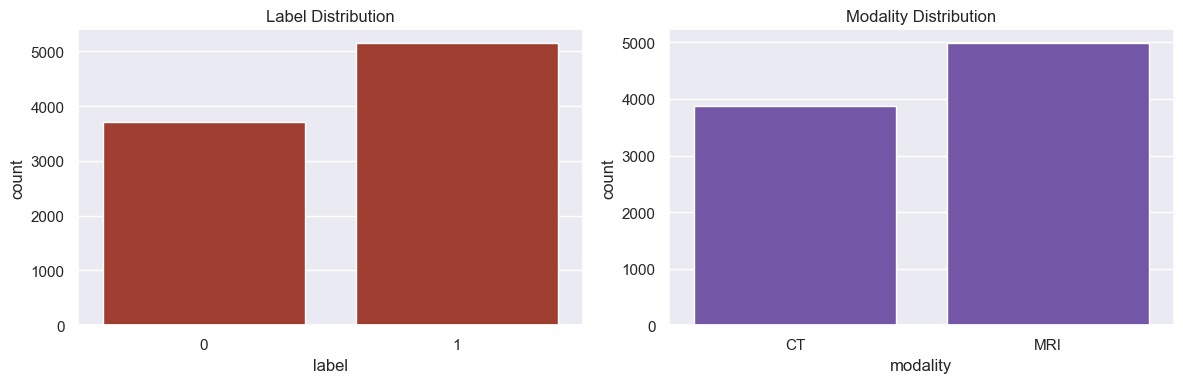

In [349]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df = pd.DataFrame(data, columns=['path', 'label', 'modality'])

sns.countplot(x='label', data=df, ax=axes[0], color="#b12f1e")
axes[0].set_title("Label Distribution")

sns.countplot(x='modality', data=df, ax=axes[1], color="#7148b4")
axes[1].set_title("Modality Distribution")

plt.tight_layout()
plt.show()


### __b) Displaying the MRI and CT scans: Tumor & Healthy images__

In [350]:
def show_random_images(df, label_filter, modality_filter, n=4):
    subset = df[(df['label'] == label_filter) & (df['modality'] == modality_filter)]
    n_to_show = min(n, len(subset))
    
    sample_rows = subset.sample(n=n_to_show, random_state=42)
    
    plt.figure(figsize=(12, 4))
    for i, (_, row) in enumerate(sample_rows.iterrows(), start=1):
        img_path = row['path']
        img = cv2.imread(img_path)
    
        plt.subplot(1, n_to_show, i)
        plt.imshow(img)
        
        lbl = "Tumor" if row['label'] == 1 else "Healthy"
        mod = row['modality']
        plt.title(f"{lbl} ({mod})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


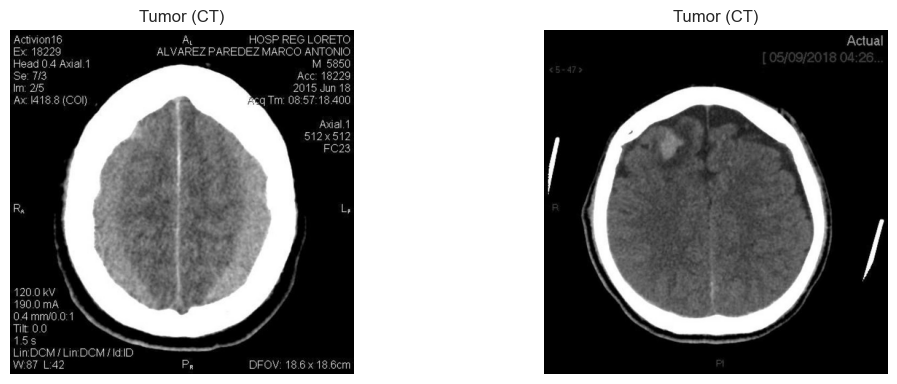

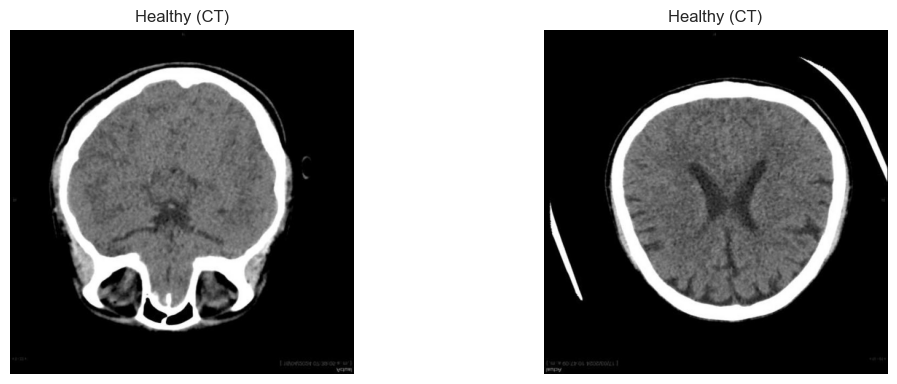

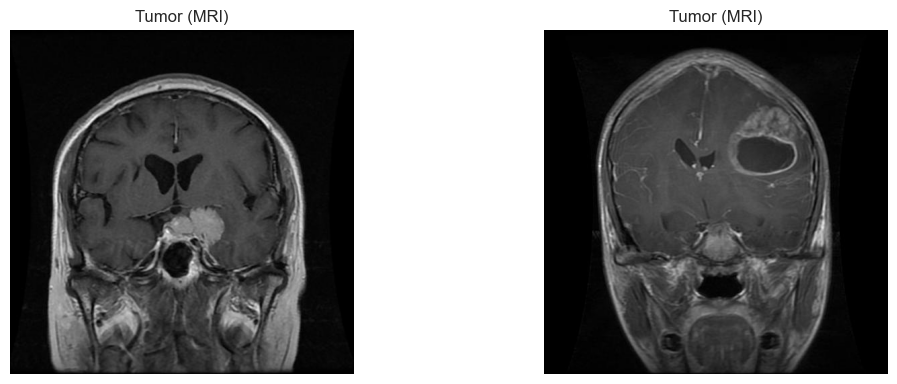

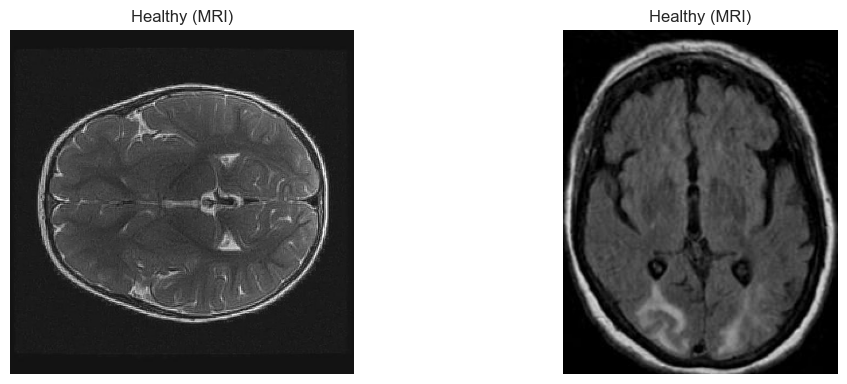

In [351]:
show_random_images(df, label_filter=1, modality_filter='CT', n=2)
show_random_images(df, label_filter=0, modality_filter='CT', n=2)
show_random_images(df, label_filter=1, modality_filter='MRI', n=2)
show_random_images(df, label_filter=0, modality_filter='MRI', n=2)

## 3) Processing data

### __a) Preparing the data__

In [356]:
label_mapping = {0: 'Healthy', 1: 'Tumor'}

df_train['label'] = df_train['label'].map(label_mapping)
df_val['label'] = df_val['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [365]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Image/Data generator
def data_generator(df, image_size):
    for index, row in df.iterrows():
        # Load image and resize
        image = tf.io.read_file(row['path'])
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, image_size)
        
        # since I am using EfficientNet, I am using their preprocess_input
        image = preprocess_input(image)
        
        label = 0 if row['label'] == 'Healthy' else 1
        
        yield image, label

train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(df_train, IMAGE_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

# validation dataset
validation_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(df_val, IMAGE_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

# Testing Dataset
test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(df_test, IMAGE_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


### __b) Establishing callbacks__

In [366]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,                 
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True,     
    verbose=1                  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]

### __c) Establishing class weights__

In [367]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)

class_weight_dict = {i: weight for i, weight in zip(np.unique(df_train['label']), class_weights)}

class_indices = train_generator.class_indices
class_weights_int = {index: class_weight_dict[class_name] for class_name, index in class_indices.items()}

## 4) EfficientNetB0 Model

In [368]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [369]:
steps_per_epoch = len(df_train) // BATCH_SIZE
validation_steps = len(df_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=3,
    callbacks=callbacks
)

Epoch 1/3
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7999 - loss: 0.4353
Epoch 1: val_accuracy improved from -inf to 0.94661, saving model to best_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8002 - loss: 0.4348 - val_accuracy: 0.9466 - val_loss: 0.1662 - learning_rate: 1.0000e-04
Epoch 2/3
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9412 - loss: 0.1725
Epoch 2: val_accuracy improved from 0.94661 to 0.95703, saving model to best_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9412 - loss: 0.1725 - val_accuracy: 0.9570 - val_loss: 0.1263 - learning_rate: 1.0000e-04
Epoch 3/3
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9579 - loss: 0.1309
Epoch 3: val_accuracy improved from 0.95703 to 0.96484, saving model to best_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9579 - loss: 0.1309 - val_accuracy: 0.9648 - val_loss: 0.1108 - learning_rate: 1.0000e-04


## 4) Evaluating the Model

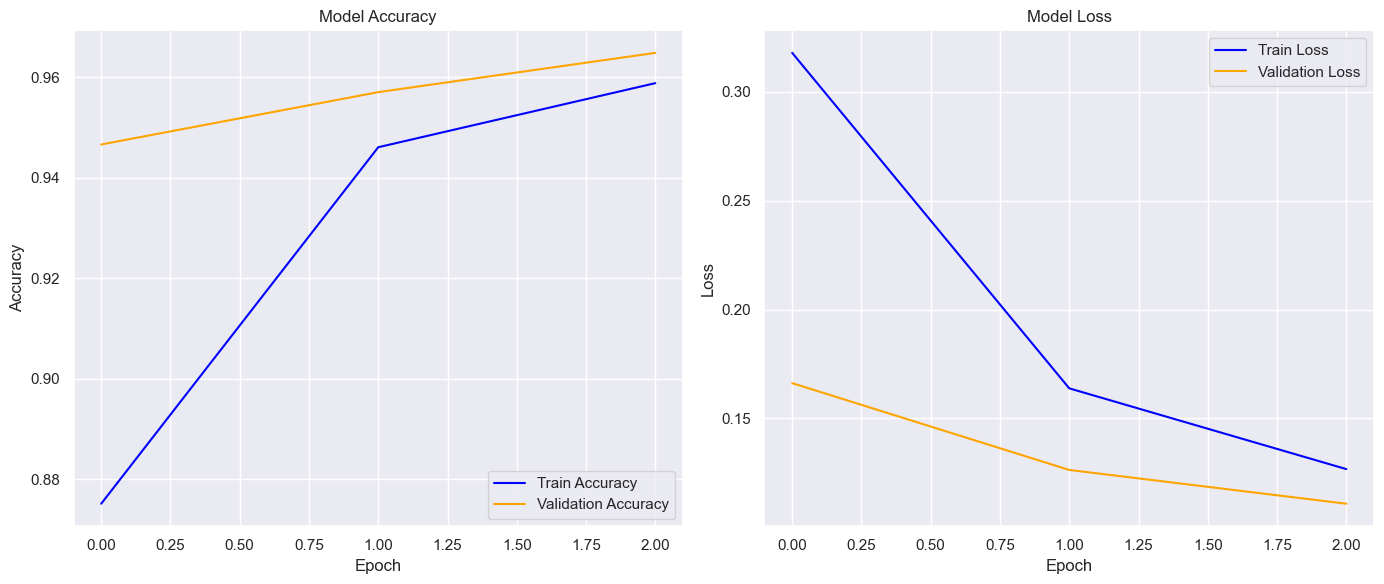

In [370]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.96      0.95      0.95       372
       Tumor       0.96      0.97      0.97       514

    accuracy                           0.96       886
   macro avg       0.96      0.96      0.96       886
weighted avg       0.96      0.96      0.96       886



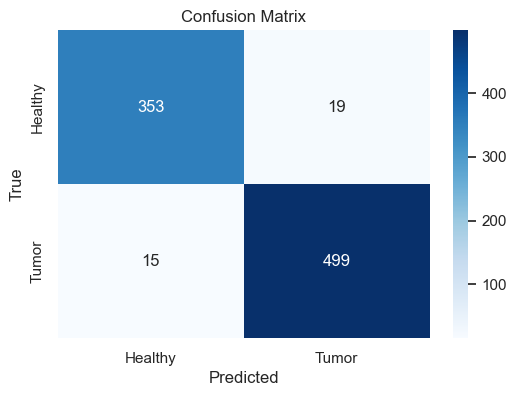

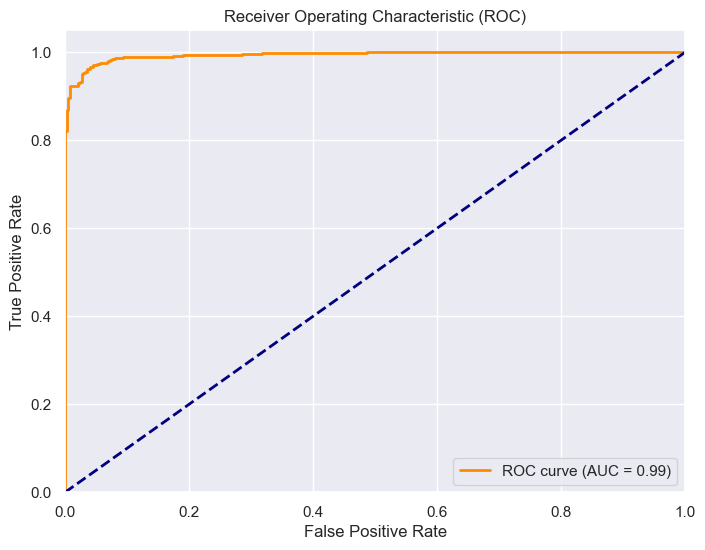

In [371]:
test_generator.reset()

pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).reshape(-1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(true_classes, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
